## Table des matières

 - [Vérification des données](#Intro)
 - [Mission 1](#chapitre_1)
     - [Années des données utilisées](#chapitre_1_1)
     - [Nombre de pays présents](#chapitre_1_2)
     - [Population couverte par l'analyse (en pourcentage de la population totale)](#chapitre_1_3)
 - [Mission 2](#chapitre_2)
     - [Diversité des pays en terme de distribution de revenus](#chapitre_2_1)
     - [Courbe de Lorenz de chacun des pays choisis](#chapitre_2_2)
     - [Évolution de l'indice de Gini au fil des ans](#chapitre_2_3)
 - [Mission 3](#chapitre_3)
 - [Mission 4](#chapitre_4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data-projet7.csv', decimal=",")

data.head(3)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0


<a id="Intro"></a>
## <span style="color: #030aa4">Vérification des données</span>

In [3]:
def data_check (df):
    df = data
    print("Vérification de la table 'data':")
    print(" ")
    print(df.dtypes)
    print(" ")
    if df.nb_quantiles.unique() == 100 :
        print ("Il y a toujours 100 quantiles.")
    else :
        print("Il n'y a pas toujours 100 quantiles.")
        
data_check(data)

Vérification de la table 'data':
 
country          object
year_survey       int64
quantile          int64
nb_quantiles      int64
income          float64
gdpppp          float64
dtype: object
 
Il y a toujours 100 quantiles.


<a id="chapitre_1"></a>
## <span style="color: #030aa4">Mission 1</span>

<a id="chapitre_1_1"></a>
### <span style="color: #a40334">Années des données utilisées</span>

In [4]:
data.year_survey.unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004])

Les données utilisées datent des années suivantes :
- 2004
- 2006
- 2007
- 2008
- 2009
- 2010
- 2011

<a id="chapitre_1_2"></a>
### <span style="color: #a40334">Nombre de pays présents</span>

In [5]:
NombrePays = data.groupby('country').count()

print("Il y a",len(NombrePays), "pays présents.")

Il y a 116 pays présents.


<a id="chapitre_1_3"></a>
### <span style="color: #a40334">Population couverte par l'analyse (en pourcentage de la population totale)</span>

In [6]:
# Chine supprimée directement lors de la sélection des données sur le site de la FAO
pop = pd.read_csv('population.csv')
codePays = pd.read_csv('Code_Pays.csv', sep=";")

# Population totale par an :
popTotaleParAn = pop.loc[ : ,('Année','Valeur')]\
                    .groupby('Année', as_index=False).sum()\
                    .rename(columns={'Valeur':'Population_totale'})

popTotaleParAn.Population_totale *=1000

# Population couverte par analyse :

popCouverte = pd.merge(pop,codePays)
popCouverte = popCouverte.loc[ : ,('Zone','Année','Valeur','country')]

data = data.rename(columns={'year_survey':'Année'})

popCouverte = pd.merge(data,popCouverte, on=['country','Année'])

# La valeur de la population est donnée pour 1000 habitants dans la table pop
# mais la poulation est divisée par centile dans la table data
# donc on doit multiplier 'Valeur' par 10

popCouverte.Valeur *= 10
popCouverte = popCouverte.groupby('Année',as_index=False).sum()
popCouverte = pd.merge(popCouverte,popTotaleParAn)
popCouverte['Population_couverte']= (popCouverte.Valeur/popCouverte.Population_totale)*100
popCouverte = popCouverte.drop(columns=['Valeur','Population_totale','quantile','nb_quantiles','income','gdpppp'])

popCouverte

,Année,Population_couverte
0,2004,0.275923
1,2006,4.341318
2,2007,40.509316
3,2008,31.664133
4,2009,6.919476
5,2010,5.517352
6,2011,0.212297


Le quantile utilisé est le **centile**.

Échantilloner la population en quantile est une bonne méthode car elle permet de constater la répartition des richesses entre groupe de même nombre.

Il est également possible de calculer des écarts et des rapports entre le dernier et le premier quantile afin de comparer la richesse des plus riches et des plus pauvres.

https://www.inegalites.fr/La-mesure-des-inegalites-qu-est-ce-qu-un-decile-A-quoi-ca-sert

https://www.youtube.com/watch?v=380mR310fA0

<a id="chapitre_2"></a>
## <span style="color: #030aa4">Mission 2</span>

<a id="chapitre_2_1"></a>
### <span style="color: #a40334">Diversité des pays en terme de distribution de revenus</span>

##### Uruguay

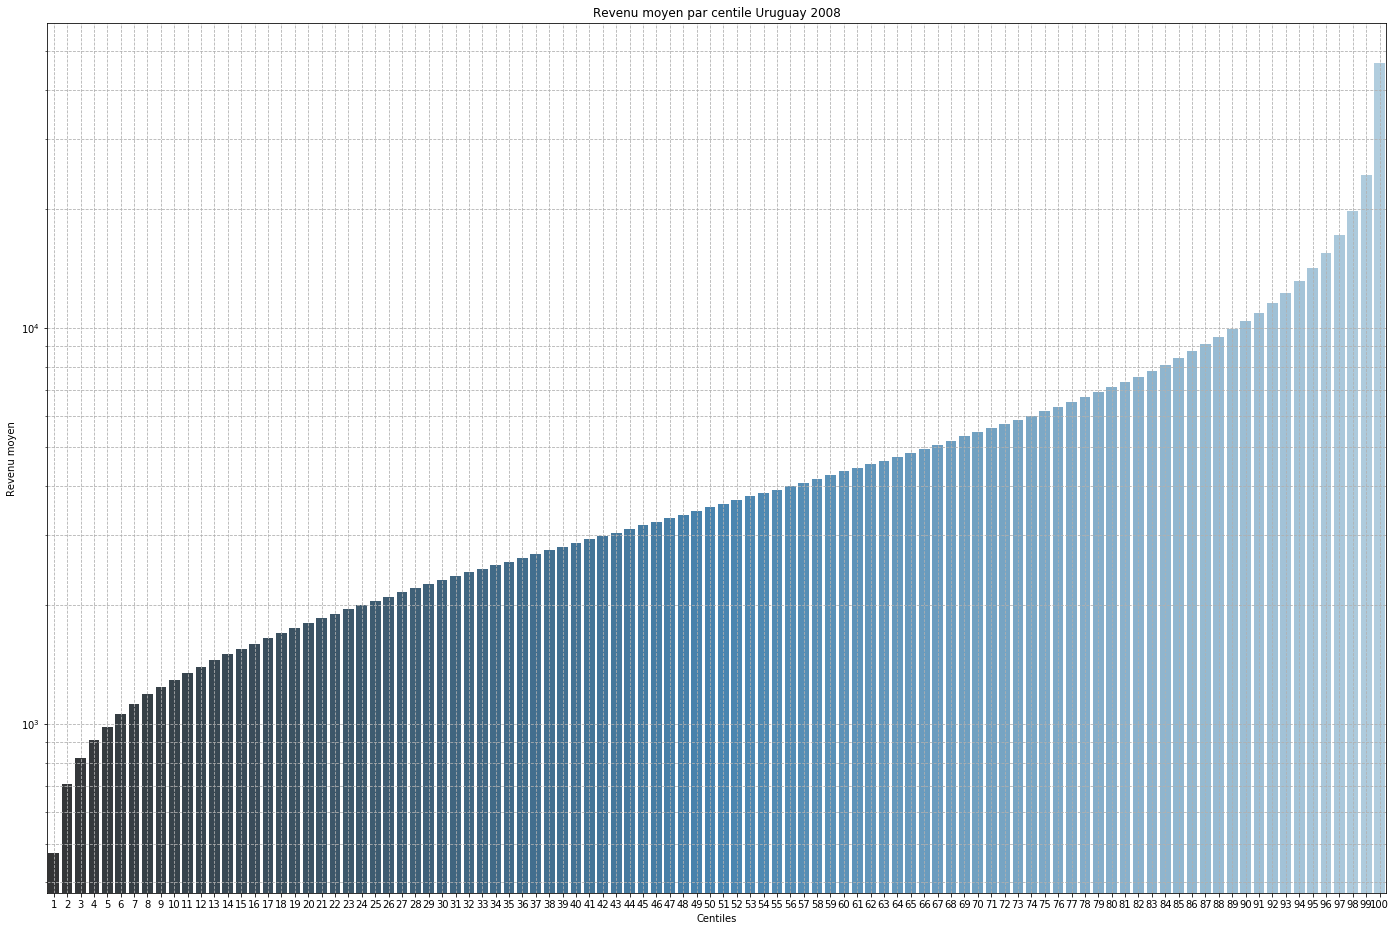

In [17]:
dataURY = data[data.country=='URY']

plt.figure(figsize=(24,16))

indx = np.arange(len(dataURY))

sns.barplot(x='quantile',y='income', data=dataURY, palette="Blues_d")

plt.ylabel('Revenu moyen')
plt.title('Revenu moyen par centile Uruguay 2008')
plt.xticks(indx)

ax = plt.axes()
ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

plt.yscale('log')

plt.grid(True,which="both", linestyle='--')

##### Luxembourg

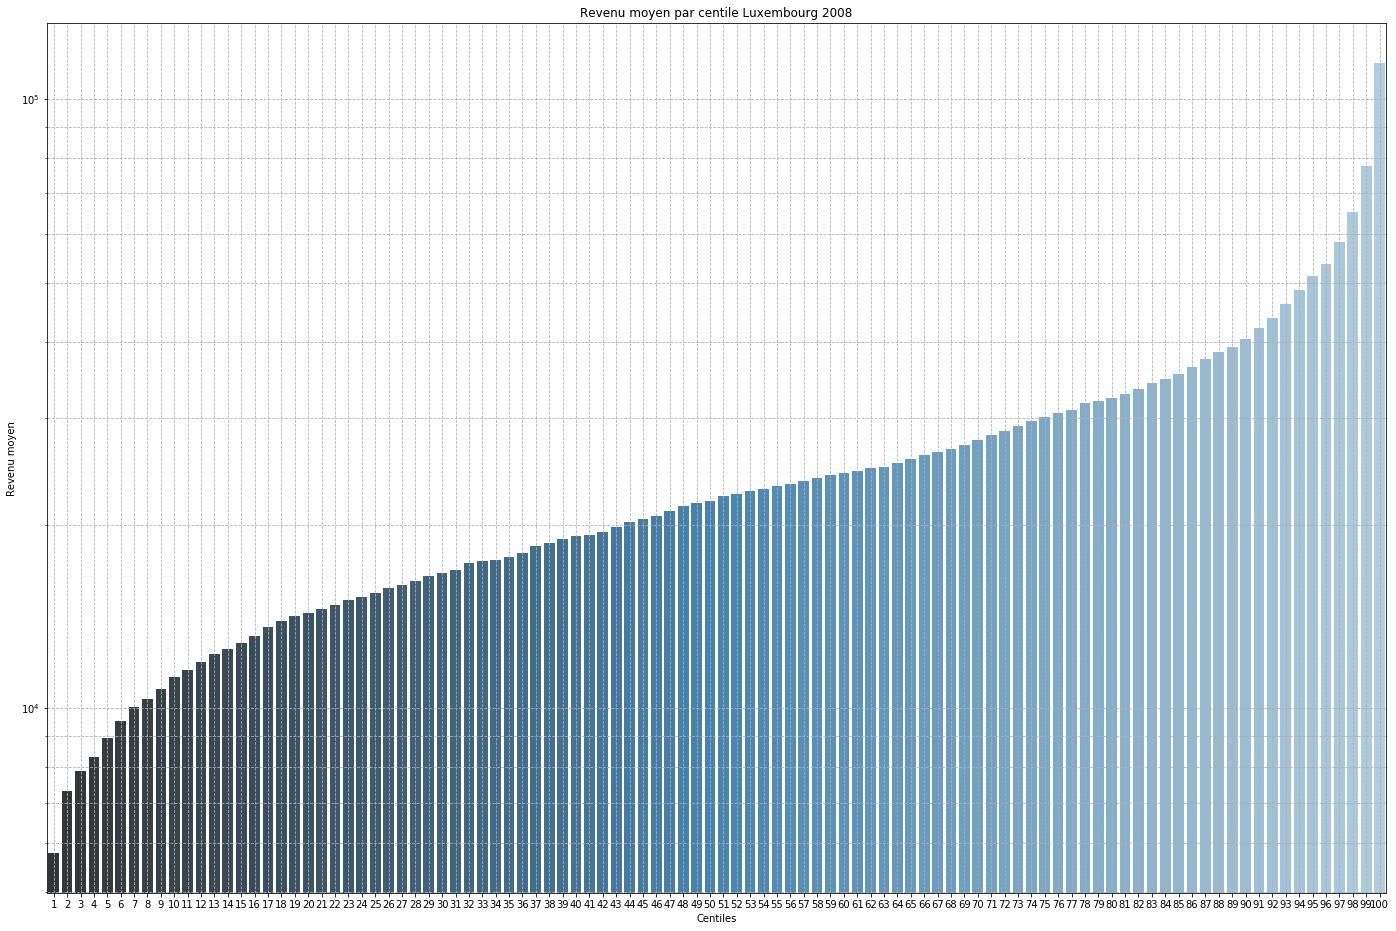

In [18]:
dataLUX = data[data.country=='LUX']

plt.figure(figsize=(24,16))

indx = np.arange(len(dataLUX))

sns.barplot(x='quantile',y='income', data=dataLUX, palette="Blues_d")

plt.ylabel('Revenu moyen')
plt.title('Revenu moyen par centile Luxembourg 2008')
plt.xticks(indx)

ax = plt.axes()
ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

plt.yscale('log')

plt.grid(True,which="both", linestyle='--')

##### Panama

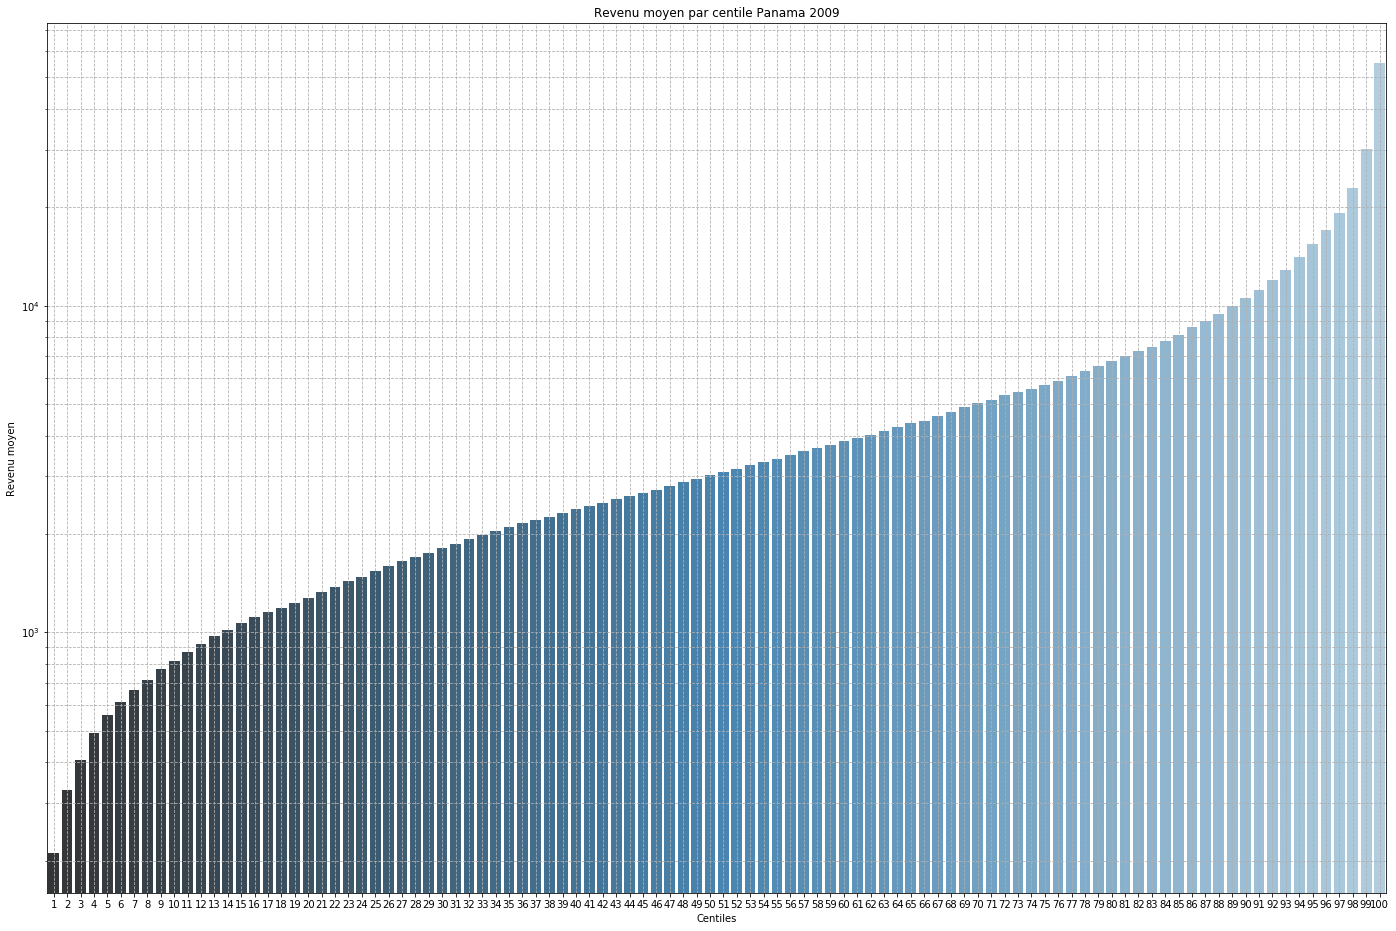

In [19]:
dataPAN = data[data.country=='PAN']

plt.figure(figsize=(24,16))

indx = np.arange(len(dataPAN))

sns.barplot(x='quantile',y='income', data=dataPAN, palette="Blues_d")

plt.ylabel('Revenu moyen')
plt.title('Revenu moyen par centile Panama 2009')
plt.xticks(indx)

ax = plt.axes()
ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

plt.yscale('log')

plt.grid(True,which="both", linestyle='--')

##### Allemagne

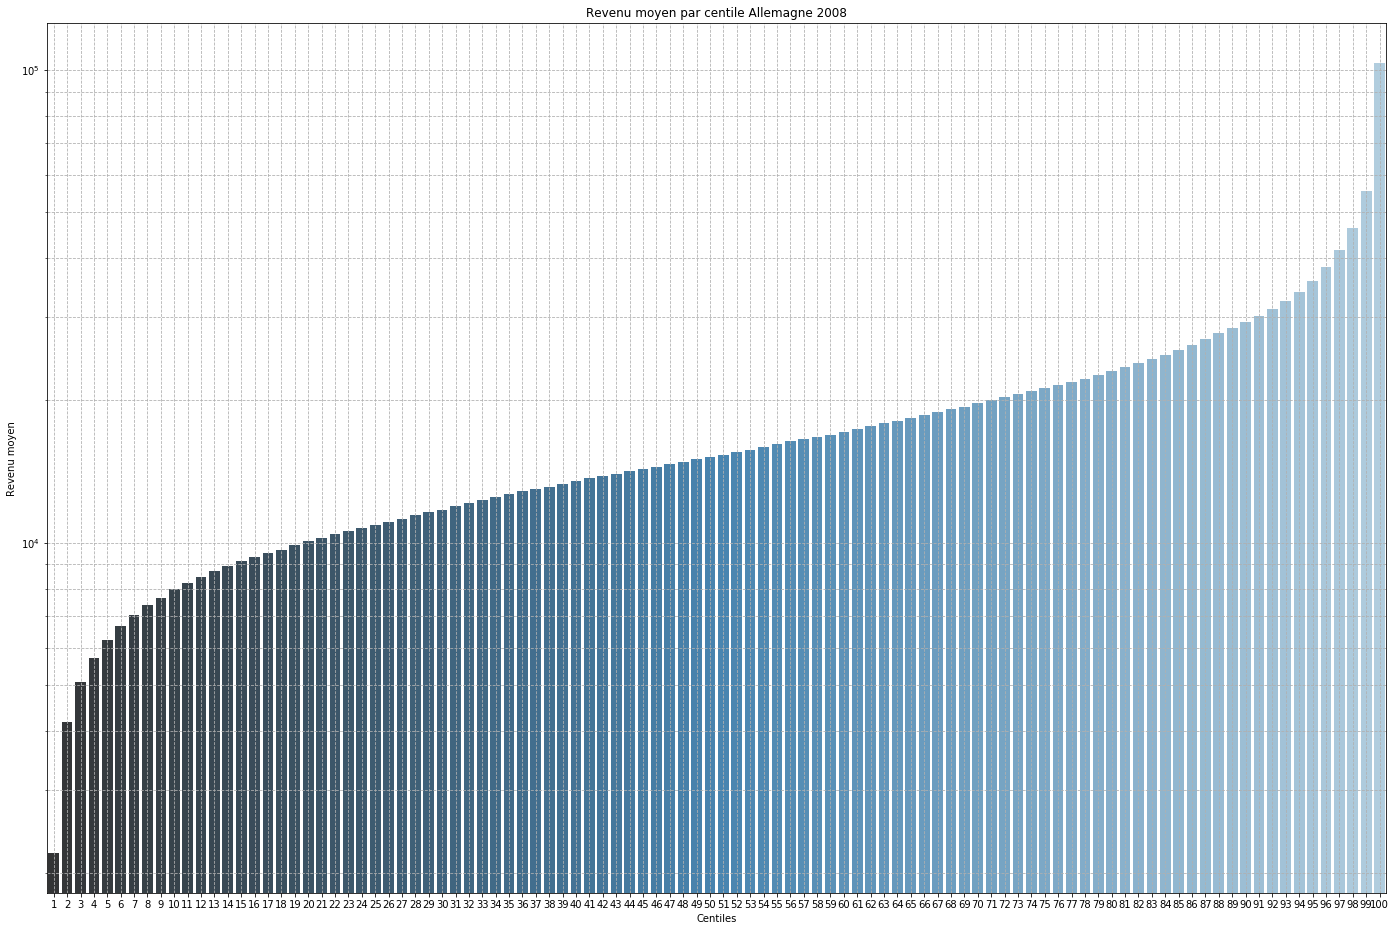

In [20]:
dataDEU = data[data.country=='DEU']

plt.figure(figsize=(24,16))

indx = np.arange(len(dataDEU))

sns.barplot(x='quantile',y='income', data=dataDEU, palette="Blues_d")

plt.ylabel('Revenu moyen')
plt.title('Revenu moyen par centile Allemagne 2008')
plt.xticks(indx)

ax = plt.axes()
ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

plt.yscale('log')

plt.grid(True,which="both", linestyle='--')

##### Danemark

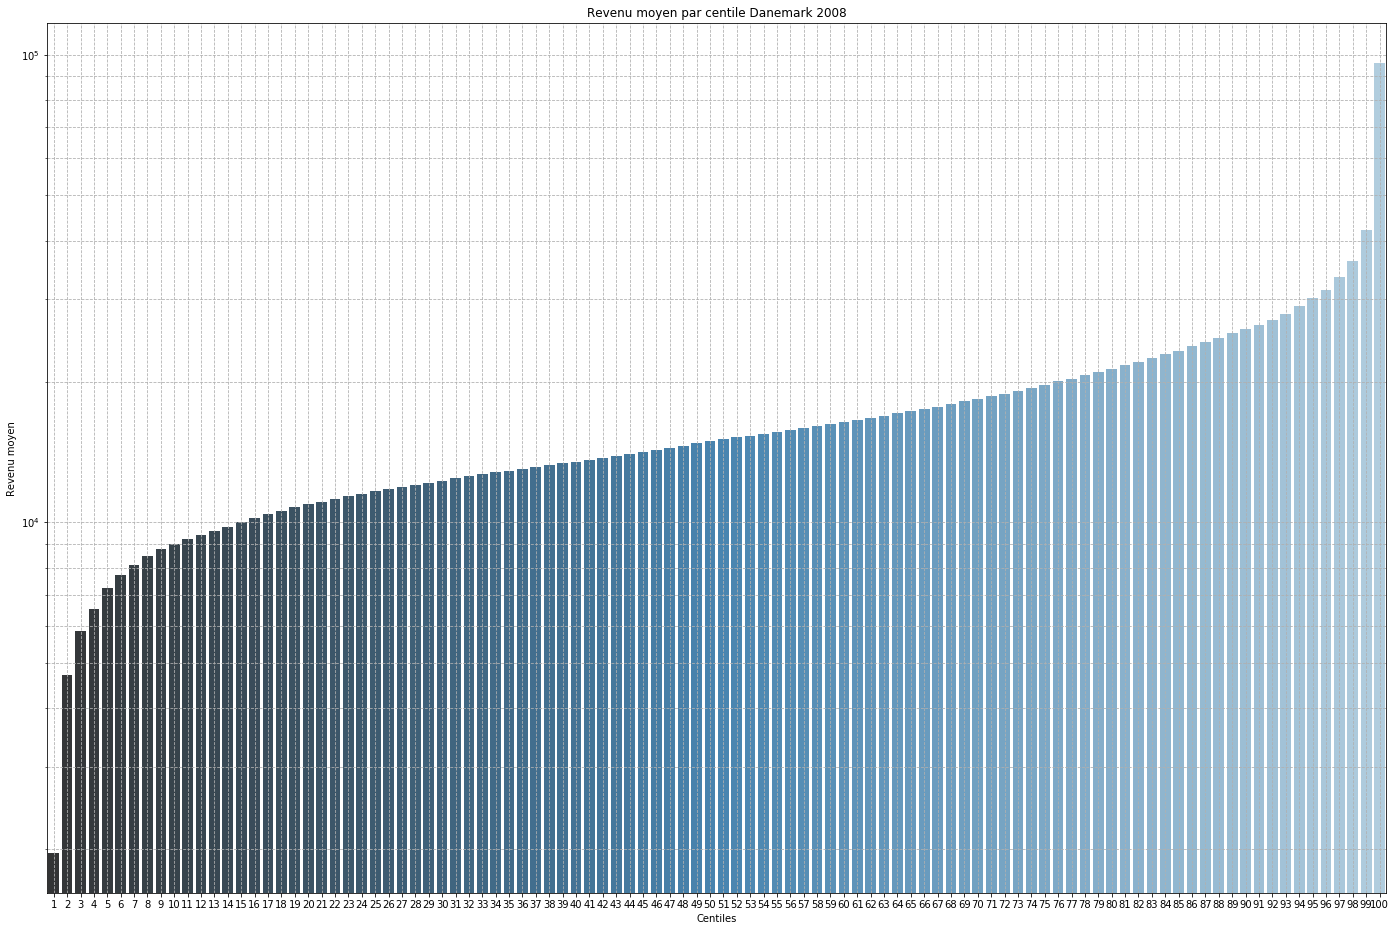

In [21]:
dataDNK = data[data.country=='DNK']

plt.figure(figsize=(24,16))

indx = np.arange(len(dataDNK))

sns.barplot(x='quantile',y='income', data=dataDNK, palette="Blues_d")

plt.ylabel('Revenu moyen')
plt.title('Revenu moyen par centile Danemark 2008')
plt.xticks(indx)

ax = plt.axes()
ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

plt.yscale('log')

plt.grid(True,which="both", linestyle='--')

##### France

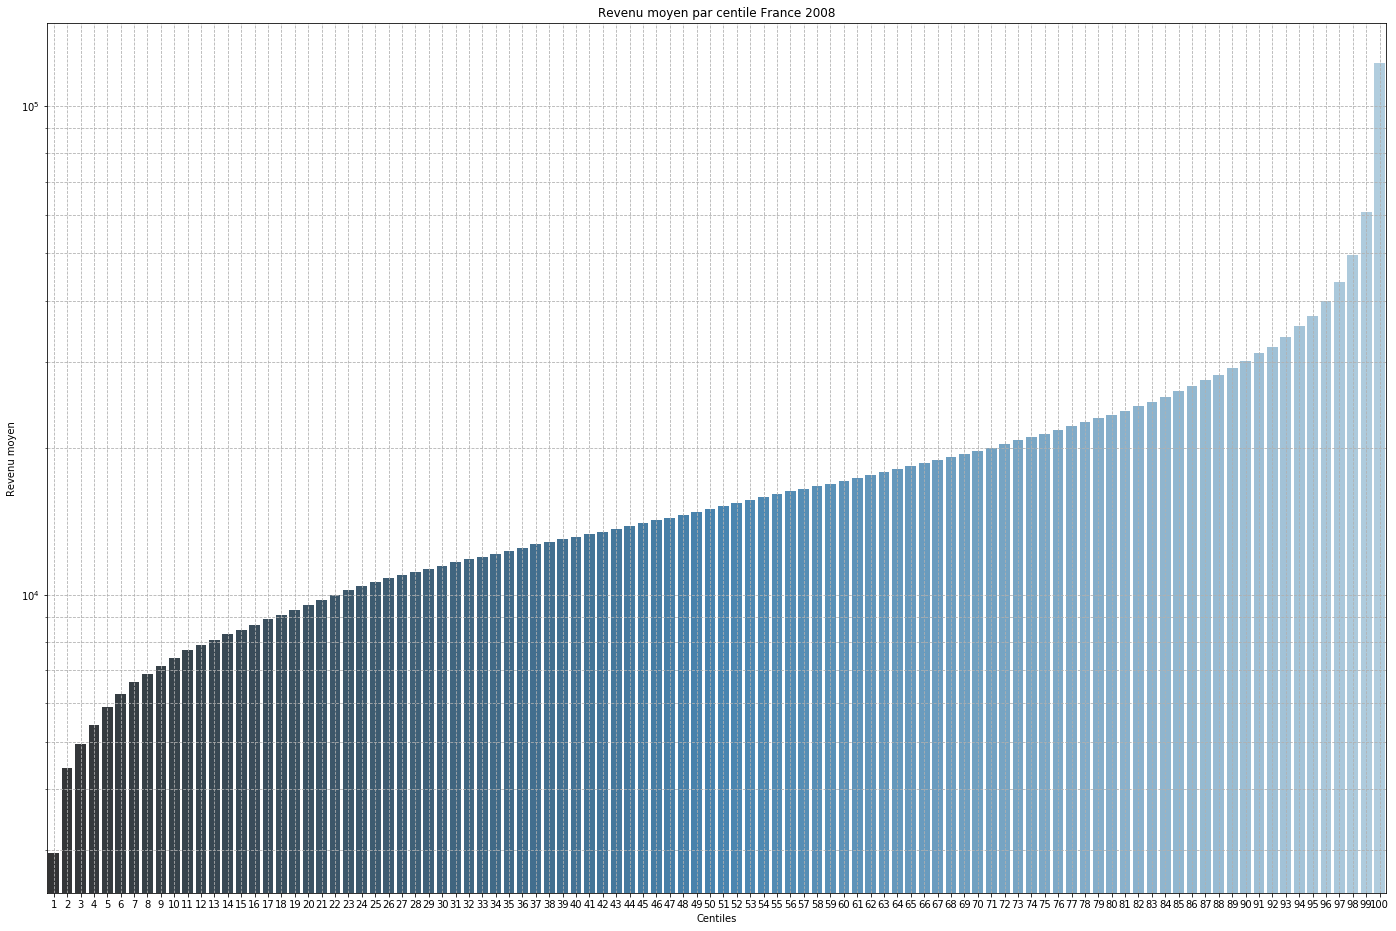

In [22]:
dataFRA = data[data.country=='FRA']

plt.figure(figsize=(24,16))

indx = np.arange(len(dataFRA))

sns.barplot(x='quantile',y='income', data=dataFRA, palette="Blues_d")

plt.ylabel('Revenu moyen')
plt.title('Revenu moyen par centile France 2008')
plt.xticks(indx)

ax = plt.axes()
ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

plt.yscale('log')

plt.grid(True,which="both", linestyle='--')

##### Indonésie

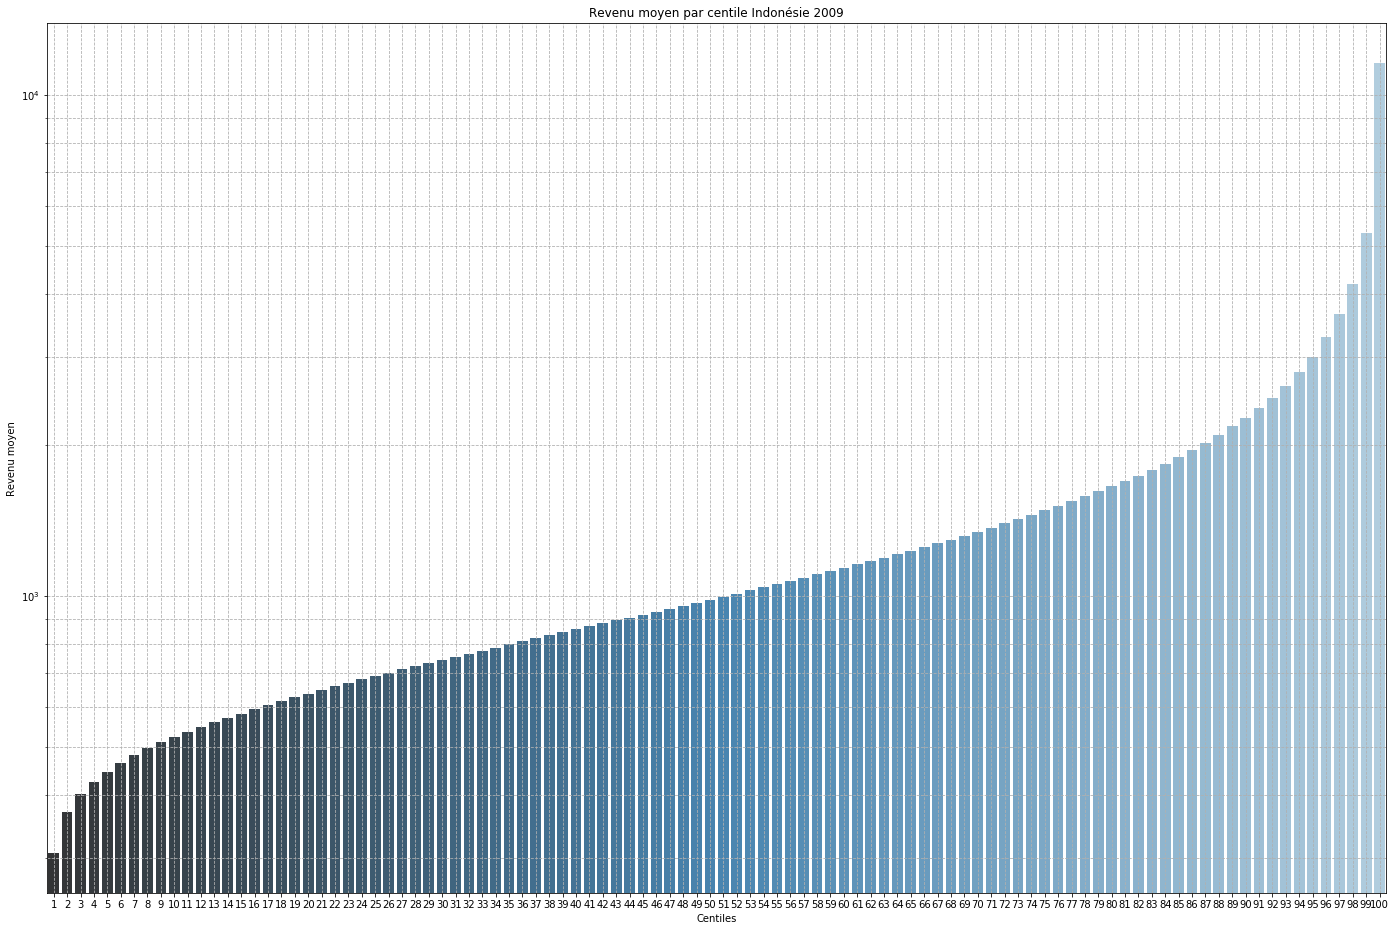

In [23]:
dataIDN = data[data.country=='IDN']

plt.figure(figsize=(24,16))

indx = np.arange(len(dataIDN))

sns.barplot(x='quantile',y='income', data=dataIDN, palette="Blues_d")

plt.ylabel('Revenu moyen')
plt.title('Revenu moyen par centile Indonésie 2009')
plt.xticks(indx)

ax = plt.axes()
ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

plt.yscale('log')

plt.grid(True,which="both", linestyle='--')

##### Kirghizistan

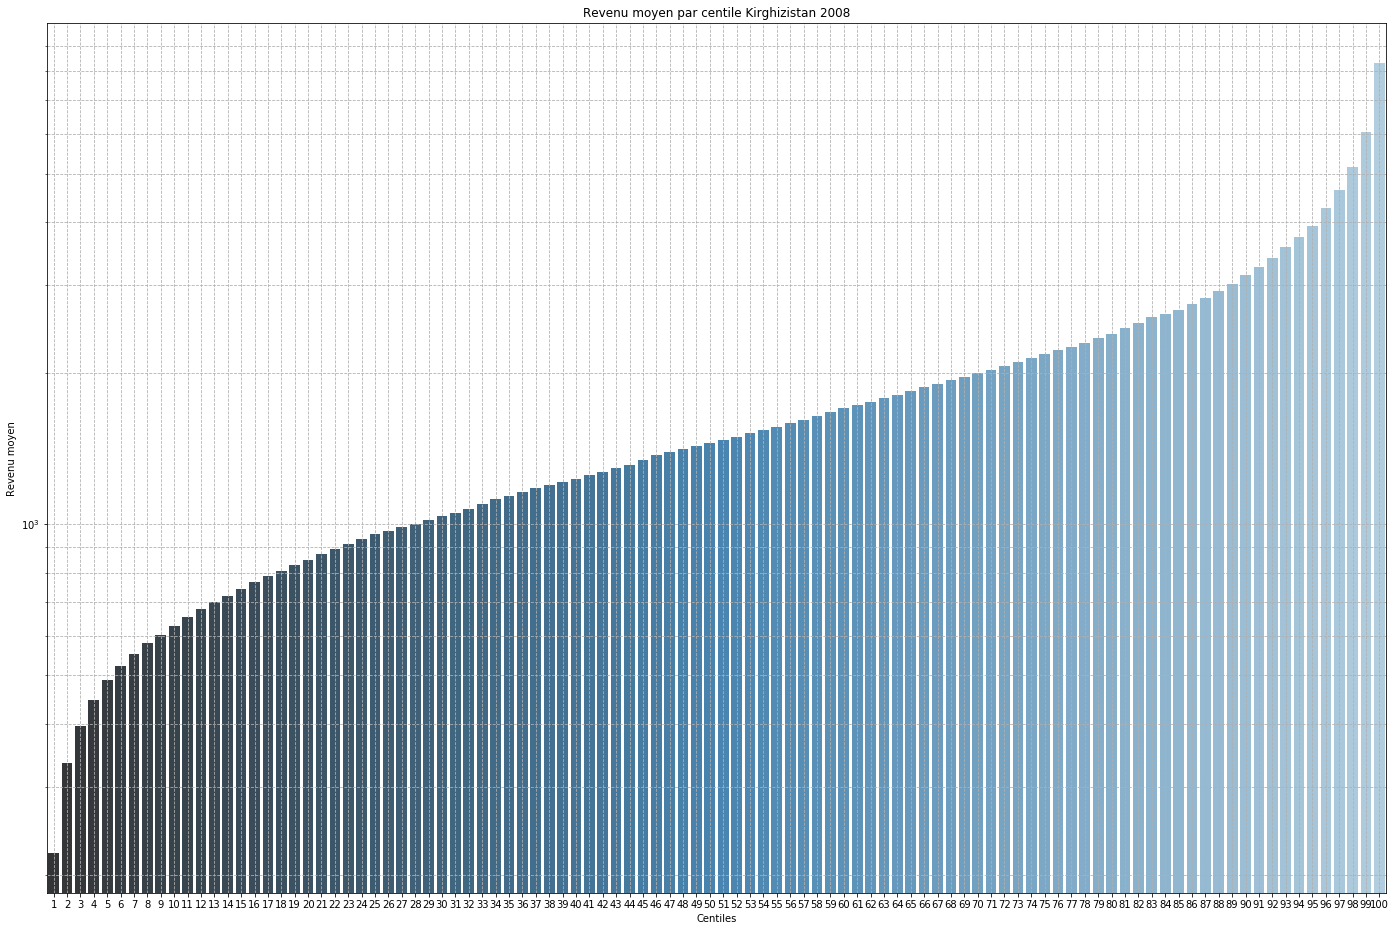

In [24]:
dataKGZ = data[data.country=='KGZ']

plt.figure(figsize=(24,16))

indx = np.arange(len(dataKGZ))

sns.barplot(x='quantile',y='income', data=dataKGZ, palette="Blues_d")

plt.ylabel('Revenu moyen')
plt.title('Revenu moyen par centile Kirghizistan 2008')
plt.xticks(indx)

ax = plt.axes()
ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

plt.yscale('log')

plt.grid(True,which="both", linestyle='--')

##### Turquie

In [ ]:
dataTUR = data[data.country=='TUR']

plt.figure(figsize=(24,16))

indx = np.arange(len(data))

sns.barplot(x='quantile',y='income', data=dataTUR, palette="Blues_d")

plt.ylabel('Revenu moyen')
plt.title('Revenu moyen par centile Turquie 2008')
plt.xticks(indx)

ax = plt.axes()
ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

plt.yscale('log')

plt.grid(True,which="both", linestyle='--')

##### Pays-Bas

NameError: name 'indx' is not defined

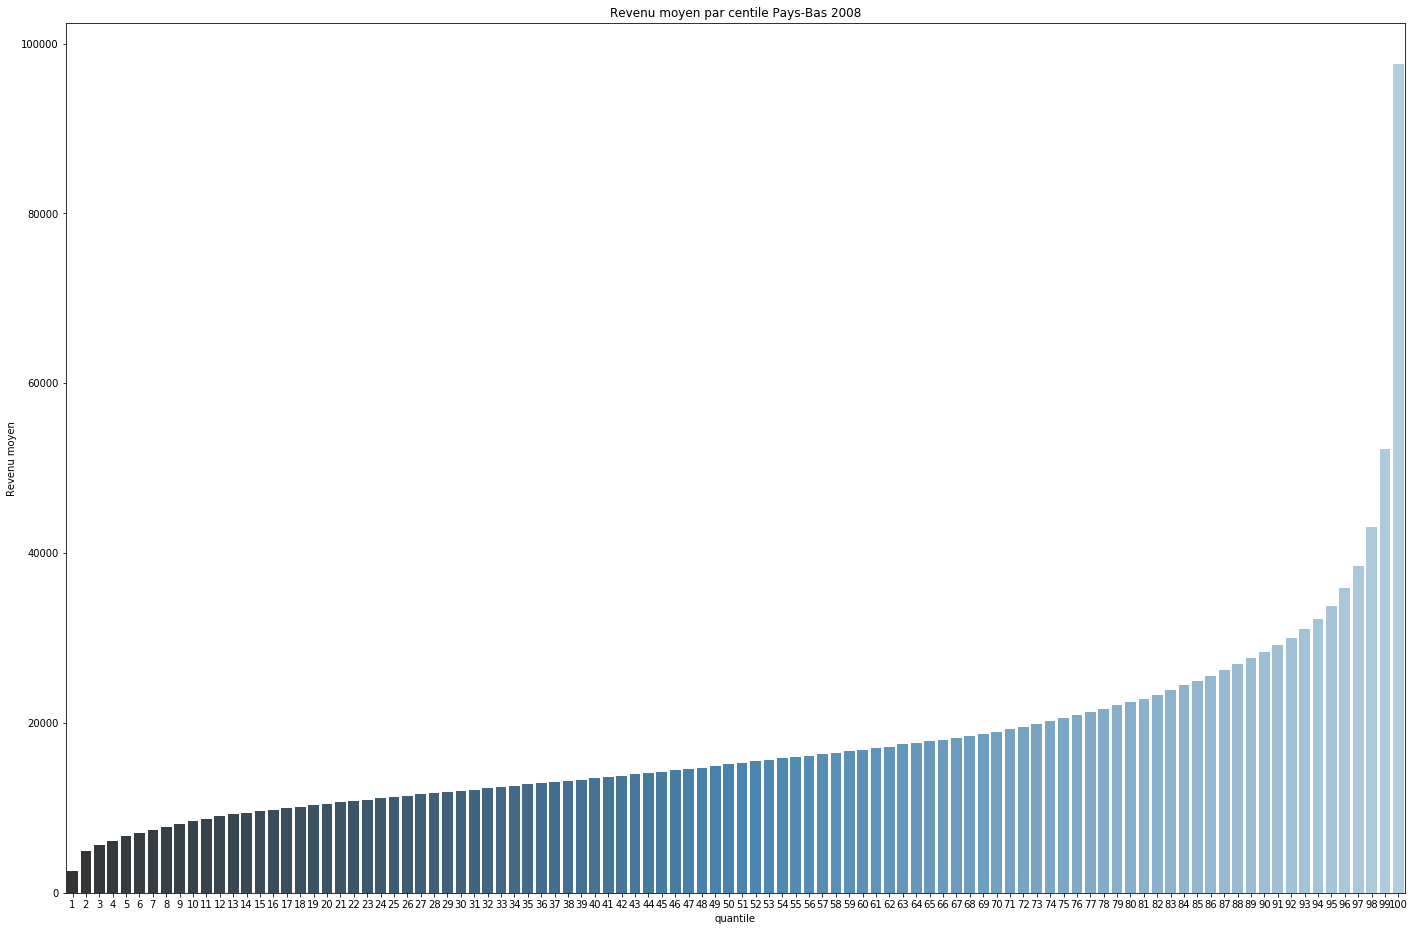

In [9]:
dataNLD = data[data.country=='NLD']

plt.figure(figsize=(24,16))

sns.barplot(x='quantile',y='income', data=dataNLD, palette="Blues_d")

plt.ylabel('Revenu moyen')
plt.title('Revenu moyen par centile Pays-Bas 2008')
plt.xticks(indx)

ax = plt.axes()
ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

plt.yscale('log')

plt.grid(True,which="both", linestyle='--')

<a id="chapitre_2_2"></a>
### <span style="color: #a40334">Courbe de Lorenz de chacun des pays choisis</span>

##### Uruguay

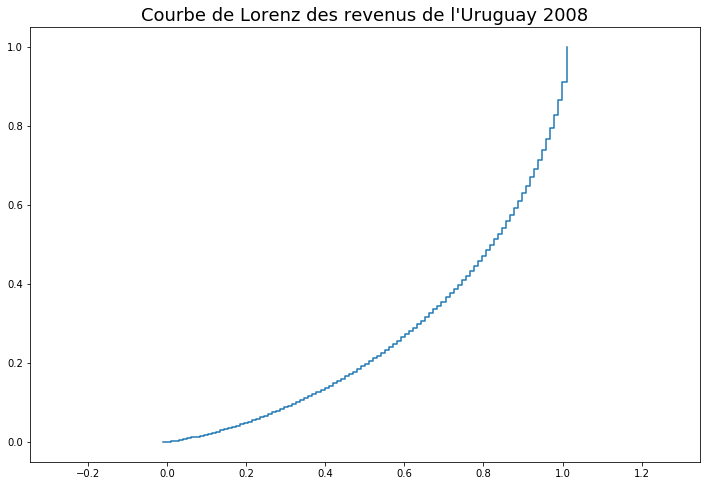

In [12]:
plt.figure(figsize=(12,8))

income = dataURY['income'].values

n = len(income)
lorenz = np.cumsum(np.sort(income)) / income.sum() 
lorenz = np.append([0],lorenz) 

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title("Courbe de Lorenz des revenus de l'Uruguay 2008", fontsize=18)

plt.show()

##### Luxembourg

In [13]:
plt.figure(figsize=(12,8))

income = dataLUX['income'].values

n = len(income)
lorenz = np.cumsum(np.sort(income)) / income.sum() 
lorenz = np.append([0],lorenz) 

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title("Courbe de Lorenz des revenus du Luxembourg 2008", fontsize=18)

plt.show()

NameError: name 'dataLUX' is not defined

<Figure size 864x576 with 0 Axes>

##### Panama

In [ ]:
plt.figure(figsize=(12,8))

income = dataPAN['income'].values

n = len(income)
lorenz = np.cumsum(np.sort(income)) / income.sum() 
lorenz = np.append([0],lorenz) 

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title("Courbe de Lorenz des revenus du Panama 2009", fontsize=18)

plt.show()

##### Allemagne

In [10]:
plt.figure(figsize=(12,8))

income = dataDEU['income'].values

n = len(income)
lorenz = np.cumsum(np.sort(income)) / income.sum() 
lorenz = np.append([0],lorenz) 

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title("Courbe de Lorenz des revenus de l'Allemagne 2008", fontsize=18)

plt.show()

NameError: name 'dataDEU' is not defined

<Figure size 864x576 with 0 Axes>

##### Danemark

In [11]:
plt.figure(figsize=(12,8))

income = dataDNK['income'].values

n = len(income)
lorenz = np.cumsum(np.sort(income)) / income.sum() 
lorenz = np.append([0],lorenz) 

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title("Courbe de Lorenz des revenus du Danemark 2008", fontsize=18)

plt.show()

NameError: name 'dataDNK' is not defined

<Figure size 864x576 with 0 Axes>

##### France

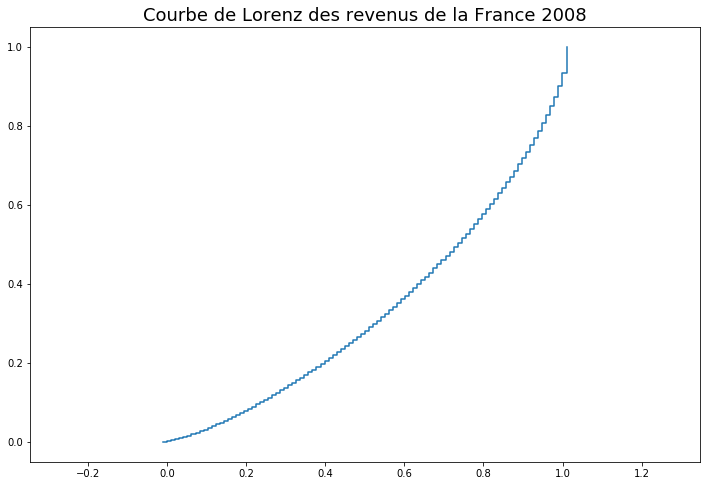

In [43]:
plt.figure(figsize=(12,8))

income = dataFRA['income'].values

n = len(income)
lorenz = np.cumsum(np.sort(income)) / income.sum() 
lorenz = np.append([0],lorenz) 

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title("Courbe de Lorenz des revenus de la France 2008", fontsize=18)

plt.show()

##### Indonésie

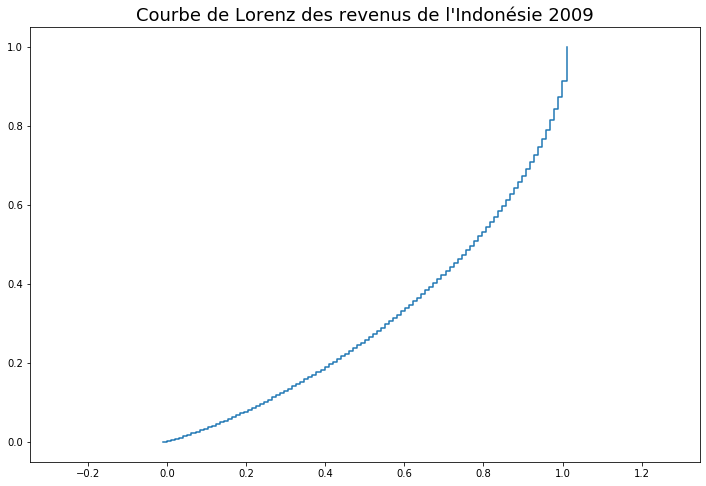

In [48]:
plt.figure(figsize=(12,8))

income = dataIDN['income'].values

n = len(income)
lorenz = np.cumsum(np.sort(income)) / income.sum() 
lorenz = np.append([0],lorenz) 

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title("Courbe de Lorenz des revenus de l'Indonésie 2009", fontsize=18)

plt.show()

##### Kirghizistan

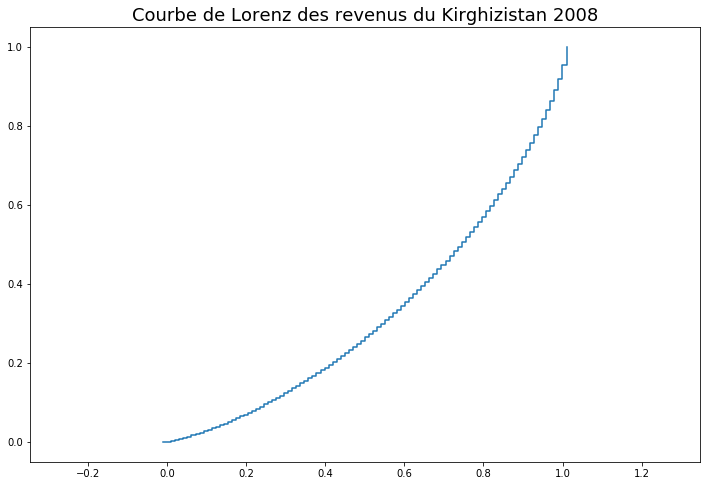

In [45]:
plt.figure(figsize=(12,8))

income = dataKGZ['income'].values

n = len(income)
lorenz = np.cumsum(np.sort(income)) / income.sum() 
lorenz = np.append([0],lorenz) 

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title("Courbe de Lorenz des revenus du Kirghizistan 2008", fontsize=18)

plt.show()

##### Turquie

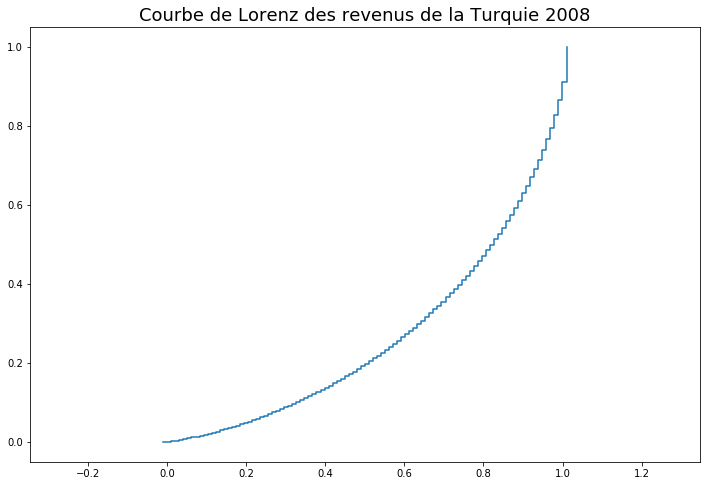

In [46]:
plt.figure(figsize=(12,8))

income = dataURY['income'].values

n = len(income)
lorenz = np.cumsum(np.sort(income)) / income.sum() 
lorenz = np.append([0],lorenz) 

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title("Courbe de Lorenz des revenus de la Turquie 2008", fontsize=18)

plt.show()

##### Pays-Bas

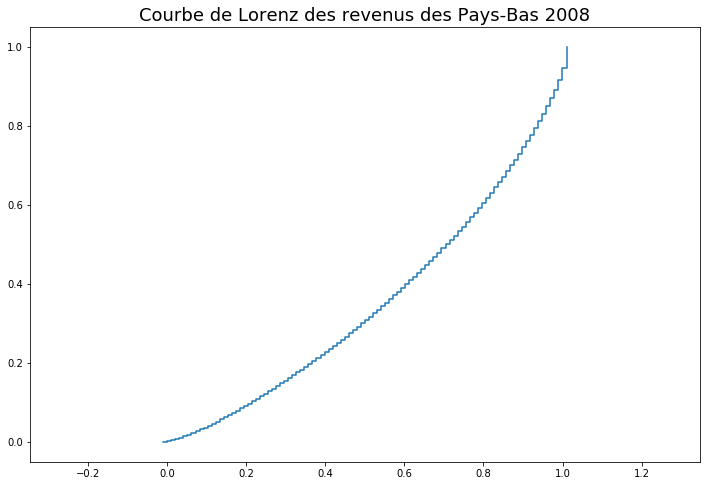

In [47]:
plt.figure(figsize=(12,8))

income = dataNLD['income'].values

n = len(income)
lorenz = np.cumsum(np.sort(income)) / income.sum() 
lorenz = np.append([0],lorenz) 

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title("Courbe de Lorenz des revenus des Pays-Bas 2008", fontsize=18)

plt.show()

<a id="chapitre_2_3"></a>
### <span style="color: #a40334">Évolution de l'indice de Gini au fil des ans</span>

In [49]:
dataGini = pd.read_csv('Gini.csv', sep=";", decimal = ",")
dataGini = dataGini.loc[:,('Country Code','2004','2006','2007','2008','2009','2010','2011')]
dataGini = dataGini.rename(columns={'Country Code':'country'})
dataGini = pd.merge(codePays,dataGini)

dataGini.head(3)

,country,Zone,2004,2006,2007,2008,2009,2010,2011
0,ALB,Albanie,NaN,NaN,NaN,30.0,NaN,NaN,NaN
1,ARG,Argentine,48.6,46.7,46.6,45.3,44.1,44.5,42.7
2,ARM,Arménie,37.5,29.7,31.2,29.2,28.0,30.0,29.4


##### Uruguay

In [51]:
GiniURY = dataGini[dataGini.country == 'URY']

GiniURY

,country,Zone,2004,2006,2007,2008,2009,2010,2011
108,URY,Uruguay,45.8,45.9,46.4,45.1,45.5,44.5,42.1


##### Luxembourg

##### Panama

##### Allemagne

##### Danemark

##### France

##### Indonésie

##### Kirghizistan

##### Turquie

##### Pays-Bas